Working on DJ
Working on UI


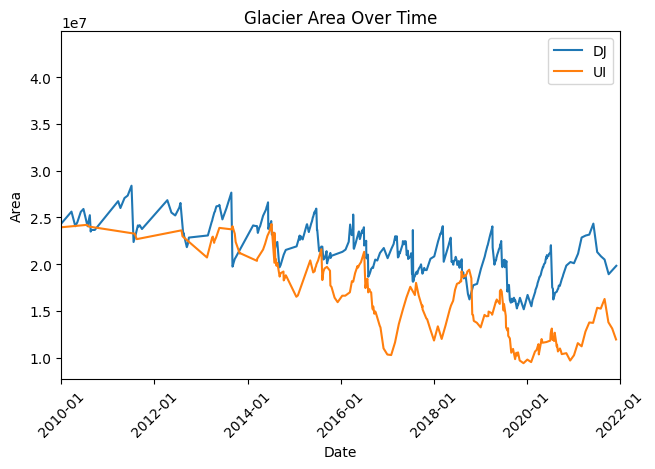

C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

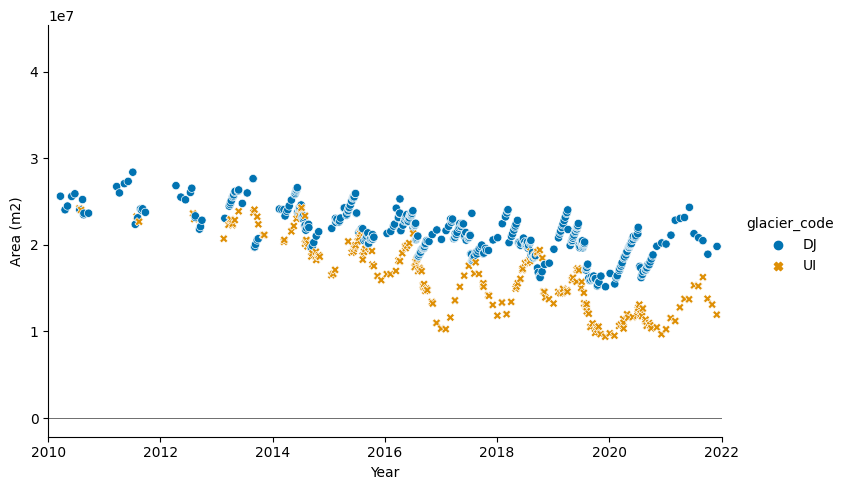

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.ops import split
from matplotlib.dates import DateFormatter
from shapely.geometry import LineString, Point

GLACIERS = ["DJ", "UI"]

terminus_boxes = gpd.read_file("../data/terminus/terminus_boxes.geojson")
terminus_positions = gpd.read_file("../data/terminus/terminus_1978_2021.geojson")

out = []

for glacier in GLACIERS:
    print(f"Working on {glacier}")

    box = terminus_boxes[terminus_boxes["glacier_code"] == glacier].reset_index()
    traces = terminus_positions[terminus_positions["glacier_code"] == glacier]

    for index, trace in traces.iterrows():
        difference = split(box.geometry[0], trace.geometry.geoms[0])

        start_relocate_distance = None
        end_relocate_distance = None

        if len(difference.geoms) == 1:
            trace_line = trace.geometry.geoms[0]
            trace_start = trace_line.coords[0]
            trace_end = trace_line.coords[-1]

            # # INITIAL STATE PLOT
            # fig, ax = plt.subplots()
            # x, y = box.geometry[0].geoms[0].exterior.xy
            # plt.plot(x, y, color="blue", alpha=0.5)
            # x, y = trace.geometry.geoms[0].xy
            # plt.plot(x, y, color="orange", alpha=0.5)
            # x, y = trace_start
            # plt.plot(x, y, color="green", marker="o", alpha=0.5)
            # x, y = trace_end
            # plt.plot(x, y, color="red", marker="o", alpha=0.5)
            # plt.title(f"initial: {index}; {trace.date}")
            # plt.show()

            nearest_start = (
                box.geometry[0]
                .geoms[0]
                .exterior.interpolate(
                    box.geometry[0].geoms[0].exterior.project(Point(trace_start))
                )
            )
            nearest_end = (
                box.geometry[0]
                .geoms[0]
                .exterior.interpolate(
                    box.geometry[0].geoms[0].exterior.project(Point(trace_end))
                )
            )

            if box.geometry[0].geoms[0].contains(Point(trace_start)):
                start_relocate_distance = nearest_start.distance(Point(trace_start))
                start_edge = (
                    box.geometry[0]
                    .geoms[0]
                    .exterior.interpolate(
                        box.geometry[0].geoms[0].exterior.project(nearest_start) - 50
                    )
                )
                start_vec = np.array(nearest_start.coords[0]) - np.array(start_edge.coords[0])
                start_perpendicular = (start_vec[1], -start_vec[0]) / np.linalg.norm(start_vec)
                trace_start_moved = (
                    nearest_start.x - start_perpendicular[0] * 50,
                    nearest_start.y - start_perpendicular[1] * 50,
                )
            else:
                trace_start_moved = trace_start

            if box.geometry[0].geoms[0].contains(Point(trace_end)):
                end_relocate_distance = nearest_end.distance(Point(trace_end))
                end_edge = (
                    box.geometry[0]
                    .geoms[0]
                    .exterior.interpolate(
                        box.geometry[0].geoms[0].exterior.project(nearest_end) + 50
                    )
                )
                end_vec = np.array(nearest_end.coords[0]) - np.array(end_edge.coords[0])
                end_perpendicular = (end_vec[1], -end_vec[0]) / np.linalg.norm(end_vec)
                trace_end_moved = (
                    nearest_end.x + end_perpendicular[0] * 50,
                    nearest_end.y + end_perpendicular[1] * 50,
                )
            else:
                trace_end_moved = trace_end

            trace_line_extended = list(trace_line.coords)
            trace_line_extended[0] = trace_start_moved
            trace_line_extended[-1] = trace_end_moved
            trace_line_extended = LineString(trace_line_extended)

            # # EXTENDED LINE PLOT
            # if trace.glacier_code == "UI":
            #     fig, ax = plt.subplots()
            #     x, y = box.geometry[0].geoms[0].exterior.xy
            #     plt.plot(x, y, color="blue", alpha=0.5)
            #     x, y = trace_line_extended.xy
            #     plt.plot(x, y, color="green", alpha=0.5)
            #     plt.title(f"extended: {index}; {trace.date}")
            #     plt.show()

            difference = split(box.geometry[0], trace_line_extended)

            # # CLOSED BOX PLOT
            # if trace.glacier_code == "UI":
            #     fig, ax = plt.subplots()
            #     x, y = difference.geoms[1].exterior.xy
            #     plt.plot(x, y, color="blue", alpha=0.5)
            #     plt.title(f"difference: {index}; {trace.date}")
            #     plt.show()

        difference_gdf = trace.drop(labels=["geometry"])
        difference_gdf["geometry"] = difference.geoms[1]
        difference_gdf["area"] = difference.geoms[1].area
        difference_gdf["start_relocated"] = start_relocate_distance
        difference_gdf["end_relocated"] = end_relocate_distance
        difference_gdf = gpd.GeoDataFrame(difference_gdf).transpose().set_geometry("geometry")
        difference_gdf.set_crs(terminus_positions.crs, inplace=True)

        out.append(difference_gdf)

out_gdf = pd.concat(out, ignore_index=True)
# out_gdf.to_file("../data/terminus/terminus_boxes-terminated.geojson", driver="GeoJSON")


# CALCULATE AND SAVE DISTANCE EACH POINT WAS EXTENDED BY AS AN ATTRIBUTE
# start_extended:  distance or null
# end_extended:    distance or null

# CALCULATE:
# area
# area change
# width-averaged retreat
# distance from minimum terminus position


# Convert the 'date' column to datetime
out_gdf["date"] = pd.to_datetime(out_gdf["date"])

# Sort the DataFrame by date
out_gdf = out_gdf.sort_values(by="date")

# Filter data for each glacier
for glacier in GLACIERS:
    glacier_data = out_gdf[out_gdf["glacier_code"] == glacier]

    # Plot area against date
    plt.plot(glacier_data["date"], glacier_data["area"], label=glacier)

# Set labels and title
plt.xlabel("Date")
plt.ylabel("Area")
plt.title("Glacier Area Over Time")
plt.legend()
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))  # Formatting x-axis date
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.xlim(pd.Timestamp("2010-01-01"), pd.Timestamp("2022-01-01"))

# Show plot
plt.show()

import seaborn as sns

fg = sns.relplot(
    data=out_gdf,
    x="date",
    y="area",
    hue="glacier_code",
    palette="colorblind",
    hue_order=GLACIERS,
    style="glacier_code",
    style_order=GLACIERS,
    aspect=1.5,
    kind="scatter",
)

fg.map(plt.axhline, y=0, c="k", linewidth=0.4)

fg.set(
    ylabel=("Area (m2)"),
    xlabel=("Year"),
    # ylim=(-410, 105),
    xlim=(pd.Timestamp("2010-01-01"), pd.Timestamp("2022-01-01")),
)
# sns.move_legend(fg, loc="lower left", bbox_to_anchor=(0.15, 0.25))
# fg.despine(trim=True)
date_fmt = DateFormatter("%Y")
fg.axes[0][0].xaxis.set_major_formatter(date_fmt)